# Hopfield 🫠

https://towardsdatascience.com/hopfield-networks-neural-memory-machines-4c94be821073

To use an Hopfield Network for a Binary image classification task we stored in the network some labeled patterns and then predict the label of a new image with the label of the pattern to which it converges.

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns


In [33]:
import numpy as np
import pathlib

from tqdm import tqdm
import random
import pygame
from scipy.spatial import distance

import tensorflow as tf
from keras import utils, layers


In [34]:
from scipy.spatial import distance

def H2(a ,b):
    return (2 * distance.hamming(a, b) - 1) ** 2

## Hopfield Class

Definition of the Hopfield network class

In [35]:
class Hopfield_Net:
    """
    n (int): number of neurons / pixel
    state (ndarray): state to work on
    energies (list): history of energy
    pointer (int): track neuron execution
    """

    def __init__(self, input):

        # patterns for network training / retrieval
        self.memory = np.array(input)
        # single vs. multiple memories
        if self.memory.size > 1:
            self.n = self.memory.shape[1]
        else:
            self.n = len(self.memory)

        # network construction
        self.energies = []  # container for tracking of energy

        self.is_stable = False

        self.pointer = 0
        self.order = list(range(self.n))
        random.shuffle(self.order)

        # learn the pattern / patterns
        self.weights = (
            (1 / self.memory.shape[0]) * self.memory.T @ self.memory
        )  # hebbian learning
        np.fill_diagonal(self.weights, 0)


    def set_state(self, state):
        self.state = np.array(state)  # state vector


    def update_network_state(self, n_update = None):  # update network
        if n_update is None:
            n_update = self.n

        for _ in range(n_update):

            self.rand_index = self.order[self.pointer]

            # Compute activation for randomly indexed neuron
            self.index_activation = np.dot(self.weights[self.rand_index, :], self.state)

            # threshold function for binary state change
            self.state[self.rand_index] = -1 if self.index_activation < 0 else 1

        self.pointer = (self.pointer + 1) % self.n

    def compute_energy(self):  # compute energy
        self.energy = -0.5 * np.dot(np.dot(self.state.T, self.weights), self.state)
        self.energies.append(self.energy)

    def let_converge(self, max_iter=200):
        while max_iter and self.is_stable:
            max_iter -= 1
            prev_state = np.array(self.state)

            self.update_network_state(self.n)
            # self.compute_energy()
            if np.all(self.state == prev_state):
                self.is_stable = True
                break

    def check_memory(self):
        counters = {i: 0 for i in ["error", "spourious", "ok"]}
        for i in range(len(self.memory)):
            self.set_state(self.memory[i])
            self.let_converge()

            ax = "spourious"
    
            for j, mem in enumerate(self.memory):
                if np.all(self.state == mem):  # converge
                    ax = (
                        "ok" if i == j else "error"
                    )  # NOTE ignore there could be duplicates inside self.memory
                    break

            counters[ax] += 1

        return counters

    def mx_reg(self):
        X, Y = self.memory, self.state
        a = np.linalg.inv(np.dot(X,X.T))
        c = np.dot(X,Y)
        beta = np.dot(a,c)
        return beta

    def lookup(self, spourious = True, ):
        if spourious:
            beta2 = self.mx_reg()**2
            idx = np.argmax(beta2) # NOTE a threshold on beta shoudld take place and therefore return a None whenever
            return idx
        else:
            for j, mem in enumerate(self.memory):
                if np.all(self.state == mem):  # converge
                    return j
            return None

    def test(self, x):
        self.set_state(x)
        self.let_converge()
        return self.lookup()

    

## HyperParam

In [36]:
img_size = 128
train_size, test_size = 50, 50
max_risk_size = 12 * 5


## Dataset

In [37]:
data_directory = pathlib.Path("downloads", "CatsDogs")
seed = 123


Downloading the dataset: as a big dataset is not needed for this network we focus just on a small sample.

In [38]:
ds_gen = utils.image_dataset_from_directory(
    data_directory,
    color_mode="grayscale",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=1,
)

Found 24770 files belonging to 2 classes.


In [39]:
ds = ds_gen.take(train_size + test_size + max_risk_size)


Converting pixels to bits

In [40]:
normalization_layer = layers.Rescaling(scale=1.0 / 255, offset=-0.5001)
normalized_ds = ds.map(lambda x, y: (normalization_layer(x), y))


In [41]:
images = []
labels = np.array([])


In [42]:
for batch in tqdm(normalized_ds):
    # sobel=tf.image.sobel_edges(batch[0])
    # sobel_x=np.asarray(sobel[0,:,:,:,1])
    arr = np.squeeze(tf.math.sign(batch[0]))
    images.append(arr)
    labels = np.append(labels, (int(batch[1][0])))
images = np.array(images)
images = images.reshape((-1, img_size * img_size))


100%|██████████| 160/160 [00:00<00:00, 284.72it/s]


In [43]:
memories_indexes = np.array(range(train_size))
test_indexes = np.array(range(train_size, train_size + test_size))


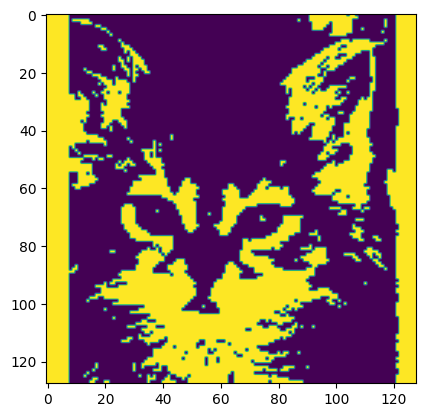

In [44]:
plt.imshow(images[9].reshape((img_size, img_size)))
plt.show()


## Testing step by step

In [45]:
memories_list = images[memories_indexes]
memories_labels = labels[memories_indexes]


In [46]:
test_image = images[27]


Initializing the network

In [47]:
H_Net = Hopfield_Net(memories_list)
H_Net.test(test_image)


27

Plotting weights matrix

In [48]:
# plt.figure("weights", figsize=(10, 7))
# plt.imshow(H_Net.weights, cmap="RdPu")  #
# plt.xlabel("Each row/column represents a neuron, each square a connection")

# plt.title(
#     f" {img_size*img_size} Neurons - {img_size*img_size*img_size*img_size} unique connections",
#     fontsize=15,
# )
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

Computing the stable state

In [49]:
# # plot energies
# plt.figure("Energy", figsize=(6, 4))
# x = np.arange(len(H_Net.energies))
# plt.scatter(x, np.array(H_Net.energies), s=1, color="red")
# plt.xlabel("Generation")
# plt.ylabel("Energy")
# plt.title("Network Energy over Successive Generations", fontsize=15)
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])


Tested image

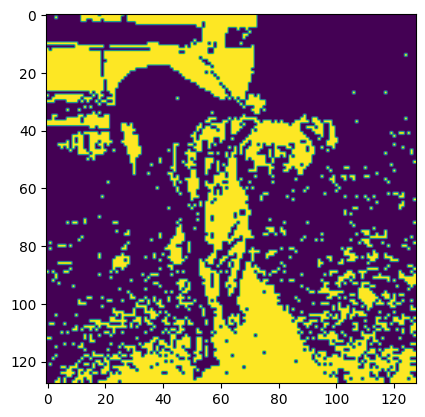

In [50]:
plt.imshow(test_image.reshape((img_size, img_size)))
plt.show()


Stable state reached

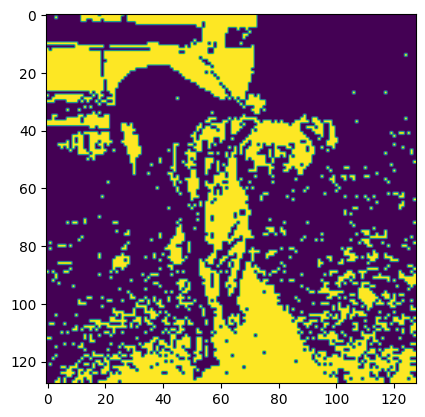

In [51]:
plt.imshow(H_Net.state.reshape((img_size, img_size)))
plt.show()


> *Binary Hopfield networks (BHNs) are prone to ‘spurious’ minima. If memories learned by a BHN are too similar, or if too many pattern vectors are learned, the network risks converging to an in-between memory, some combination of learned patterns; in other words, the network will fail to discriminate between patterns and becomes useless.*

Checking if it is a spurius state or if the network predicted well

In [52]:
H_Net.check_memory()

{'error': 0, 'spourious': 0, 'ok': 50}

## Exploratory experiments

As any pattern stored define a stable state, this network should have always zero training error.

### Train

In [53]:
H_Net = Hopfield_Net(memories_list)
print(f"PERFORMANCE ON THE TRAINING SET: {H_Net.check_memory()}")

PERFORMANCE ON THE TRAINING SET: {'error': 0, 'spourious': 0, 'ok': 50}


### Test

In [54]:
not_guessed = 0
spurius_states = []

for index in tqdm(test_indexes):
    result = H_Net.test(images[index])

    if result is None:
        spurius_states.append(index)
    else:
        if memories_labels[result] == labels[index]:
            pass
        else:
            not_guessed += 1

100%|██████████| 50/50 [00:00<00:00, 176.30it/s]


In [55]:
print("PERFORMANCE ON THE TEST SET:")
print(f"Number of spurius states reached: {len(spurius_states)}")

try:
    loss = not_guessed / (test_size-len(spurius_states))
except ZeroDivisionError:
    print(f"Loss cannot be computed right now")
else:
    print(f"Net 0:1 loss: {loss}")


PERFORMANCE ON THE TEST SET:
Number of spurius states reached: 0
Net 0:1 loss: 0.6


In practice, even with a small number of patterns stored there is the risk that a some of the learned pattern converge instead to a spurius pattern.

It seems necessary to choose the patterns stored trying to minimizing the risk of spurius states. To do so the patterns stored need to be as dissimilar as possible.

So, we define an enreached algorithm using an Hopfield Network for binary image classification:

It take as inputs a training set of labeled images.
It has one parameters: **p** that is the number of patterns to be stored >=2.

First it choose **p** images from the training set, ensuring that there is at least one pattern for each label and maximizing the dissimilarity examples.

Then it stored these patterns with an Hopfield Network.

In [56]:
def pattern_chooser(training_images, training_labels, p: int):
    """
    this procedure ensure that at least one pattern per label is keeped as long as p>=2

    Args:
        p (int): number of pattern to choose

    Returns:
        this procedure delete one pattern at time
        and if there is just one pattern with a label value it can't be deleted as:
        its label count is 1 so:
        or the other label has a higher count than one,
        or it already reach the minimum number of patterns left that is 2 and will not delete any pattern
    """
    
    patterns = np.array(training_images)
    patterns_labels = np.array(training_labels)

    # build dinstance matrix
    dists = np.array([[H2(a, b) for a in patterns] for b in patterns])
    np.fill_diagonal(dists, 1)

    while len(patterns_labels) > p:
        # a, b = np.where(dists == dists.min())[0]
        a, b = np.unravel_index(np.argmin(dists, axis=None), dists.shape)
        label_a, label_b = patterns_labels[[a, b]]

        # delete the pattern with the most represented label
        idx = b if sum(patterns_labels == label_a) < sum(patterns_labels == label_b) else b

        patterns = np.delete(patterns, idx, 0)
        patterns_labels = np.delete(patterns_labels, idx, 0)
        dists = np.delete(dists, idx, 0)
        dists = np.delete(dists, idx, 1)

        # print(patterns_labels, patterns.shape)

    return patterns, patterns_labels


### Hyperparameter tuning

In [57]:
stats = dict()

for p in tqdm(range(2, train_size, 2)):
    perf = {i+'_val':0 for i in ["error", "spourious", "ok"]}
    # choose patterns
    memories_list, memories_labels = pattern_chooser(images[memories_indexes], labels[memories_indexes], p)
    H_Net = Hopfield_Net(memories_list)
    
    for index in tqdm(test_indexes):
        result = H_Net.test(images[index])

        if result is None:
            perf['spourious_val'] += 1
        else:
            if memories_labels[result] == labels[index]:
                perf['ok_val'] += 1
            else:
                perf['error_val'] += 1

    stats[p] = (H_Net.check_memory(), perf)

100%|██████████| 24/24 [00:26<00:00,  1.11s/it]


[Text(0.5, 0, 'N of patterns'), Text(0, 0.5, 'Loss')]

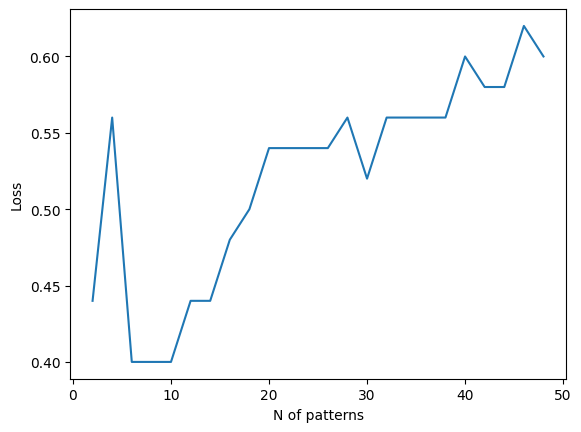

In [58]:
ax = sns.lineplot(x=list(stats.keys()), y=[v[1]['error_val'] /(test_size) for v in stats.values()])
ax.set(xlabel="N of patterns", ylabel='Loss')

In [59]:
N_PATTERN = 8

### Risk estimation

In [60]:
K = 5
tt_size = train_size + test_size
risk_size = N_PATTERN * K if True else max_risk_size
risk_indexes = np.array(range(tt_size, tt_size + risk_size))
fold_size = risk_size // K

In [61]:
loss = [0]*K

for i in range(K):
    lx, rx = i * fold_size, (i + 1) * fold_size
    memories_indexes = np.arange(lx, rx)
    memories_list, memories_labels = images[memories_indexes], labels[memories_indexes]
    # memories_list, memories_labels = pattern_chooser(images[memories_indexes], labels[memories_indexes], N_PATTERN)

    test_indexes = np.delete(risk_indexes, memories_indexes, 0)

    H_Net = Hopfield_Net(memories_list)
    print(f"Fold nº {i+1}...")

    for index in tqdm(test_indexes):
        result = H_Net.test(images[index])
        if memories_labels[result] != labels[index]:
            loss[i] += 1

Fold nº 1...


100%|██████████| 32/32 [00:00<00:00, 1526.22it/s]


Fold nº 2...


100%|██████████| 32/32 [00:00<00:00, 1013.76it/s]


Fold nº 3...


100%|██████████| 32/32 [00:00<00:00, 1129.98it/s]


Fold nº 4...


100%|██████████| 32/32 [00:00<00:00, 1864.39it/s]


Fold nº 5...


100%|██████████| 32/32 [00:00<00:00, 1386.62it/s]


In [62]:
sum(loss)/K/risk_size

0.40499999999999997

### Animation

In [63]:
cellsize = 5

pygame.init() 
surface = pygame.display.set_mode((img_size * cellsize, img_size * cellsize))
pygame.display.set_caption("")

('display Surface quit',)


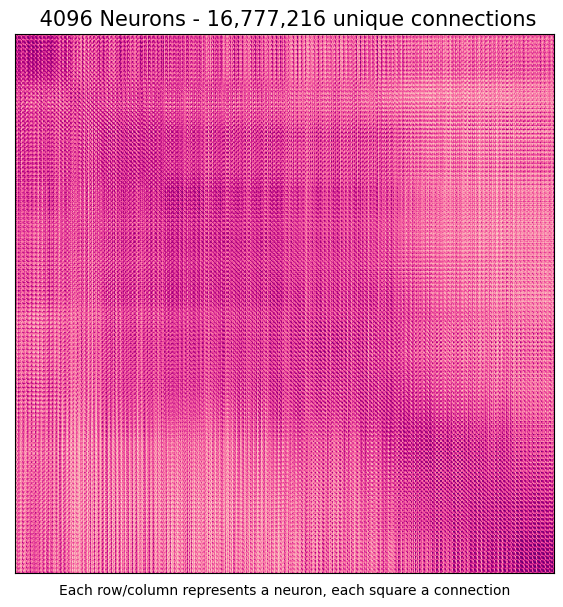

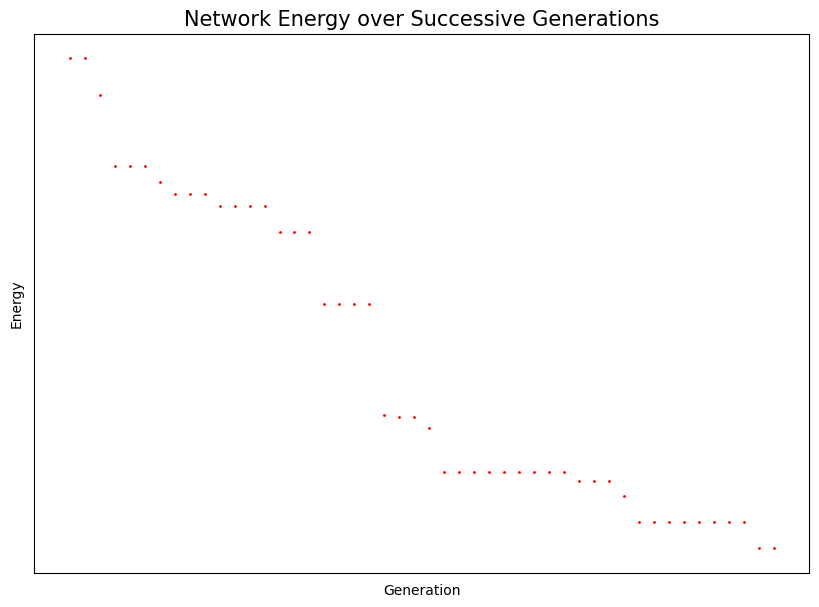

In [64]:
# kill pygame if user exits window
Running = True
# main animation loop
try:
    while Running:
        for event in pygame.event.get():
            pygame.time.wait(1)
            if event.type == pygame.QUIT:
                Running = False

                # plot weights matrix
                plt.figure("weights", figsize=(10, 7))
                plt.imshow(H_Net.weights, cmap="RdPu")  #
                plt.xlabel("Each row/column represents a neuron, each square a connection")

                plt.title(" 4096 Neurons - 16,777,216 unique connections", fontsize=15)
                plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

                # plot energies
                plt.figure("Energy", figsize=(10, 7))
                x = np.arange(len(H_Net.energies))
                plt.scatter(x, np.array(H_Net.energies), s=1, color="red")
                plt.xlabel("Generation")
                plt.ylabel("Energy")
                plt.title("Network Energy over Successive Generations", fontsize=15)
                plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

                # quit pygame
                pygame.quit()

        cells = H_Net.state.reshape(img_size, img_size).T

        # fills surface with color
        surface.fill((211, 211, 211))

        # loop through network state array and update colors for each cell
        for r, c in np.ndindex(cells.shape):  # iterates through all cells in cells matrix
            if cells[r, c] == -1:
                col = (135, 206, 250)

            elif cells[r, c] == 1:
                col = (0, 0, 128)

            else:
                col = (255, 140, 0)
            pygame.draw.rect(
                surface, col, (r * cellsize, c * cellsize, cellsize, cellsize)
            )  # draw new cell_

        # update network state
        H_Net.update_network_state(100)
        H_Net.compute_energy()
        pygame.display.update()  # updates display from new .draw in update function
except Exception as inst:
    print(inst.args)
